In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, EllipticEnvelope, GraphicalLassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_approximation import Nystroem

# from sklearnex import patch_sklearn

# patch_sklearn()

plt.style.use("seaborn-v0_8")

In [2]:
random_state = 42

df = pd.read_csv("train.csv")

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

test_size = 0.3

# "stratify" is set because the target is very imbalanced
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, stratify=df_y, random_state=random_state)
print("Train: {}\nTest: {}".format(X_train.shape, X_test.shape))

Train: (176522, 90)
Test: (75653, 90)


---
# Preprocessing

- [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) is tested
- [Shrinkage, Oracle Approximating Shrinkage (OAS)](https://en.wikipedia.org/wiki/Shrinkage_(statistics)#:~:text=In%20statistics%2C%20shrinkage%20is%20the,coefficient%20of%20determination%20'shrinks') is tested because requires normal distributed data
- [Empirical covariance](https://scikit-learn.org/stable/modules/covariance.html#empirical-covariance) is tested because requires normal distributed data
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) is tested because it's robust to anomalies, requires normal and unimodal distributed data
- LDA with eigenvalues solver for dimensionality reduction

In [10]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    # ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    # ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),
    # ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    # (
    #     "min-max + lmax + pca 0.95",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("pca", PCA(random_state=random_state)),
    #     ],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    # (
    #     "min-max + lda2",
    #     [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             # GraphicalLassoCV(cv=3), # too much computational expensive
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    # (
    #     "min-max + lmax + lda2",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("lda", LinearDiscriminantAnalysis()),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             # GraphicalLassoCV(cv=3), # too much computational expensive
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    (
        "min-max + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010, 0.09, 0.08],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
]

---
---
# Modeling
- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters
- Then it's chosen the best model with the best preprocess method looking at the R^2 score
- "StratifiedKFold" is chosen to keep the proportion of imbalanced target lables

In [15]:
def gridSearch(name_estimator, estimator, param_estimator, cv):
    searches = {}
    predictions = {}
    for name_step, transformers, param_grid in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe,
            param_grid={**param_estimator, **param_grid},
            # n_jobs=-1,
            cv=cv,
            verbose=3,
            pre_dispatch=8,
        )

        gs.fit(X_train.values, y_train)

        y_pred = gs.best_estimator_.predict(X_test.values)

        searches[name_step] = gs
        predictions[name_step] = y_pred

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
            )
        )
    return searches, predictions

In [16]:
def print_store_results(searches: dict, predictions: dict, name_est):
    best_r2_score = -100
    best_preprocessor = []
    best_estimator = None
    best_search_name = None

    for name_step, gs in searches.items():
        r2 = r2_score(y_test, predictions[name_step])

        if r2 > best_r2_score:
            best_r2_score = r2
            best_search_name = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but estimator
            best_estimator = gs.best_estimator_[-1]

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2, mean_squared_error(y_test, predictions[name_step])
            )
        )

        if name_step in [
            "min-max + pca",
            "min-max + pca 0.95",
            "min-max + std-scaler + pca 0.95",
            "min-max + lmax + pca 0.95",
            "min-max + lda1",
            "min-max + lda2",
            "min-max + lda3",
            "std-scaler + lda2",
            "min-max + lmax + lda2",
        ]:
            ratio = gs.best_estimator_[-2].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["min-max + lda + nystroem"]:
            ratio = gs.best_estimator_[-3].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["lda1", "lda2", "lda3"]:
            ratio = gs.best_estimator_[0].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["min-max + ica"]:
            print("\t\t{}: number of components={}".format(name_step, len(gs.best_estimator_[1].components_)))

    file = open(name_est + "_preproc_" + ".save", "wb")
    pickle.dump(best_preprocessor, file)
    file = open(name_est + "_model_" + ".save", "wb")
    pickle.dump(best_estimator, file)
    file.close()

    print("\nSAVED: ----> {} data. R^2: {}".format(best_search_name, best_r2_score))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.grid(None)
    fig.tight_layout()
    cmp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        np.round(predictions[best_search_name]).astype(int),
        ax=ax,
        xticks_rotation=80,
        include_values=False,
        cmap="gist_stern",  # "magma",
        colorbar=False,
    )
    ax.plot(range(len(cmp.confusion_matrix)), range(len(cmp.confusion_matrix)), color="white", linestyle="dotted")
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(cmp.im_, cax=cax)
    plt.show()

---
## SVM

In [17]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "svr__epsilon": [0.01],
    "svr__C": [10],  # 0.1, 1, 100, 500, 5, 20, 8, 9,15
    # "svr__fit_intercept": [True, False],
    "svr__max_iter": [2000],
    # "svr__intercept_scaling": [1, 2]
}

searches, predictions = gridSearch("svr", LinearSVR(dual="auto", random_state=random_state), param_estimator, cv)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END lda__covariance_estimator=OAS(), lda__solver=eigen, nys__gamma=0.01, nys__n_components=1000, svr__C=10, svr__epsilon=0.01, svr__max_iter=2000;, score=0.272 total time=  16.5s
[CV 2/3] END lda__covariance_estimator=OAS(), lda__solver=eigen, nys__gamma=0.01, nys__n_components=1000, svr__C=10, svr__epsilon=0.01, svr__max_iter=2000;, score=0.272 total time=  14.8s
[CV 3/3] END lda__covariance_estimator=OAS(), lda__solver=eigen, nys__gamma=0.01, nys__n_components=1000, svr__C=10, svr__epsilon=0.01, svr__max_iter=2000;, score=0.277 total time=  16.2s
[CV 1/3] END lda__covariance_estimator=OAS(), lda__solver=eigen, nys__gamma=0.09, nys__n_components=1000, svr__C=10, svr__epsilon=0.01, svr__max_iter=2000;, score=0.149 total time=  11.9s


----> min-max + lda + nystroem data. Params: {'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.018, 'nys__n_components': 1000, 'svr__C': 10, 'svr__epsilon': 0.01, 'svr__max_iter': 2000}. R^2: 0.2851687344672509. MSE: 78.77186307418741
		min-max + lda + nystroem: number of components=53, total variance=1.491844798635474

SAVED: ----> min-max + lda + nystroem data. R^2: 0.2851687344672509


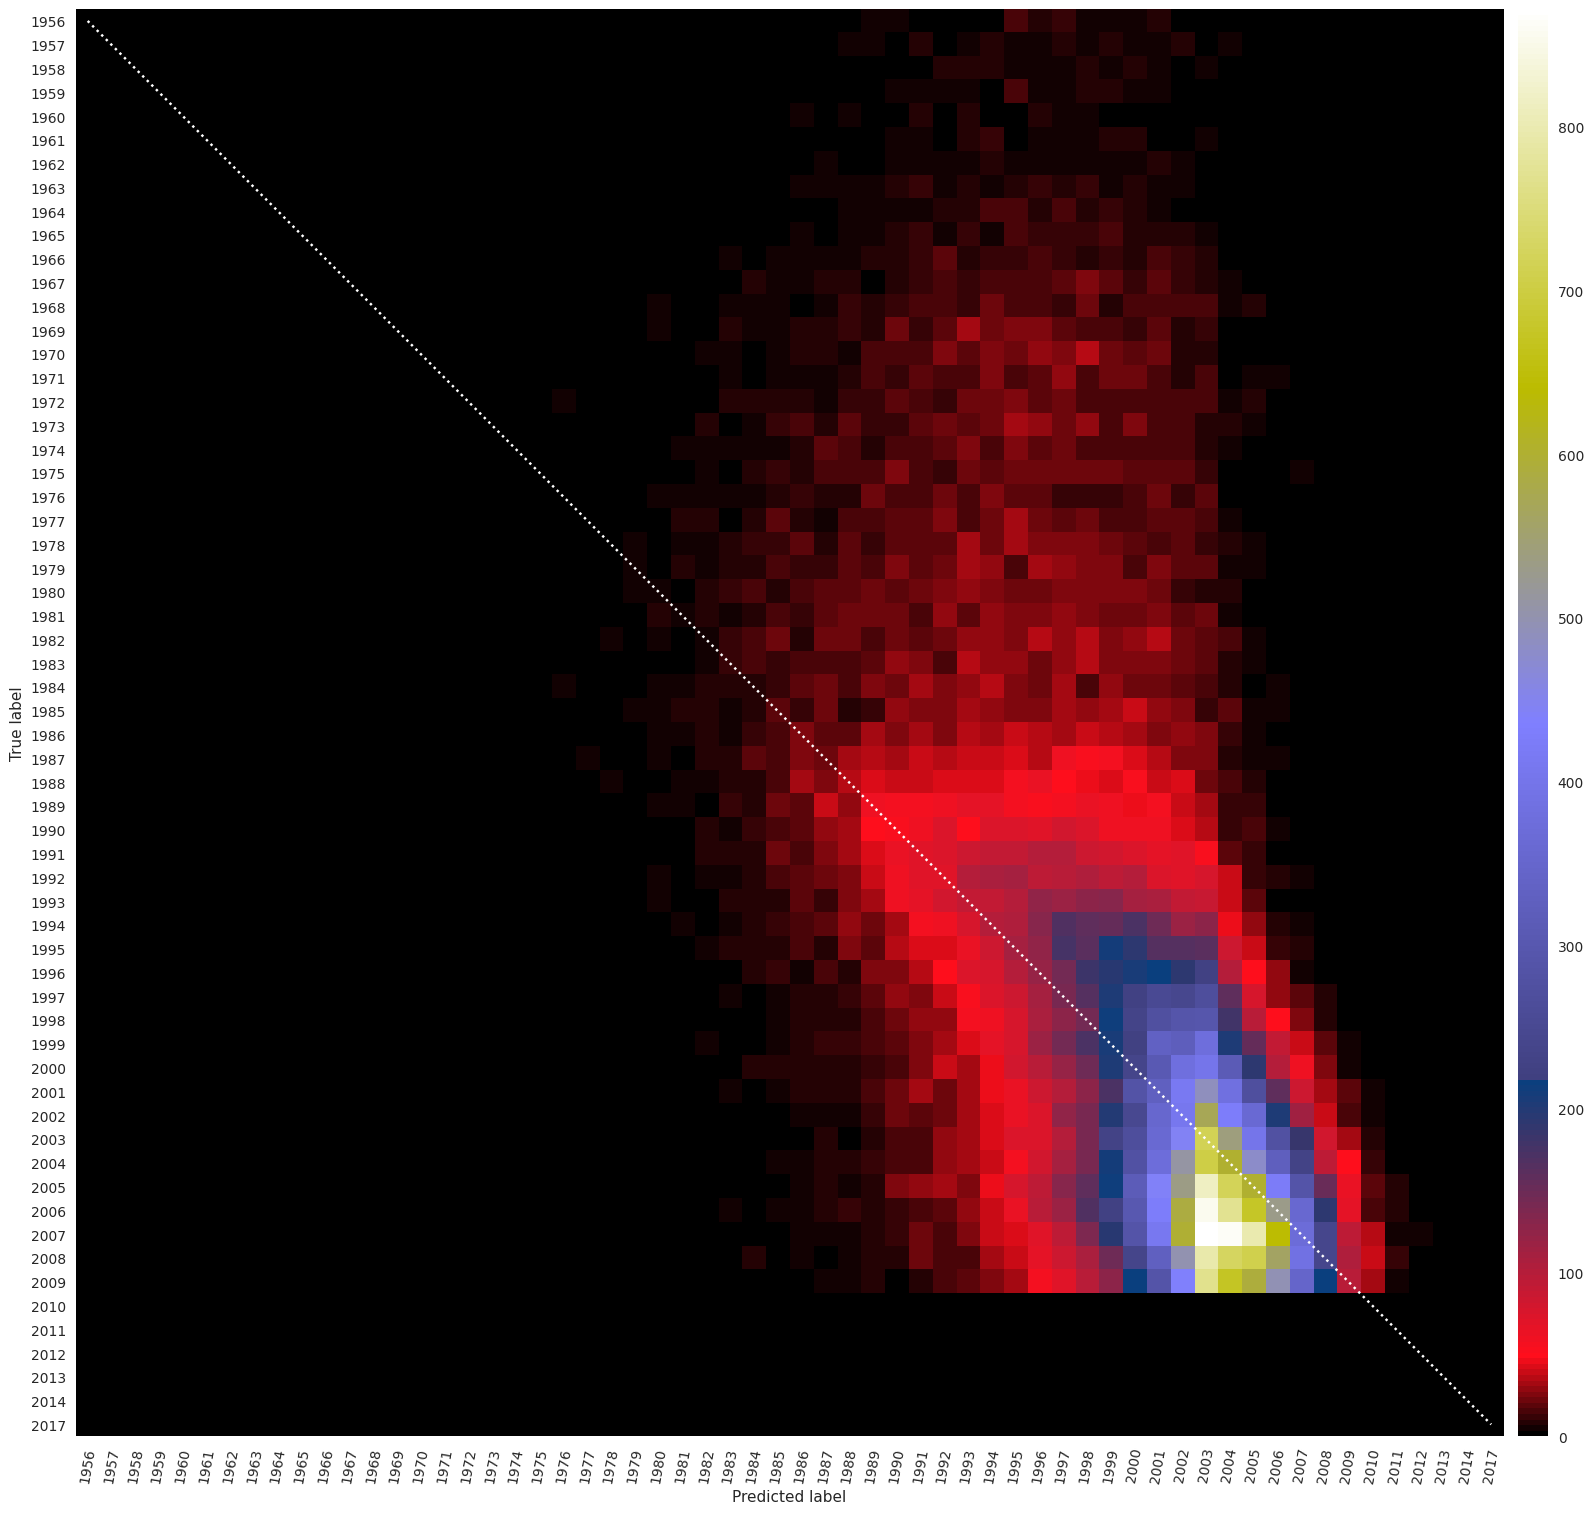

In [ ]:
print_store_results(searches, predictions, "svr")

---
## Linear Regression
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA is a bit better than PCA but with fewer components (53)
- The result R^2=0.237, MSE=83.99, are given with all the following:
    - Raw data
    - Standard-scaled data
    - Min-max + LDA with EmpiricalCovariance as covariance estimators and "eigen" solver
    - Min-max + LDA with "svd" solver and store_covariance=True
- The best results are R^2=0.242,  MSE=83.47 with Min-max + l-max-Normalization + LDA with EmpiricalCovariance

In [6]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {}

searches, predictions = gridSearch("lr", LinearRegression(), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.2418228902377194. MSE: 83.54842094332174


----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.2418228902377194. MSE: 83.54842094332174
		min-max + lmax + lda2: number of components=53, total variance=1.4228327061439383

SAVED: ----> min-max + lmax + lda2 data. R^2: 0.2418228902377194


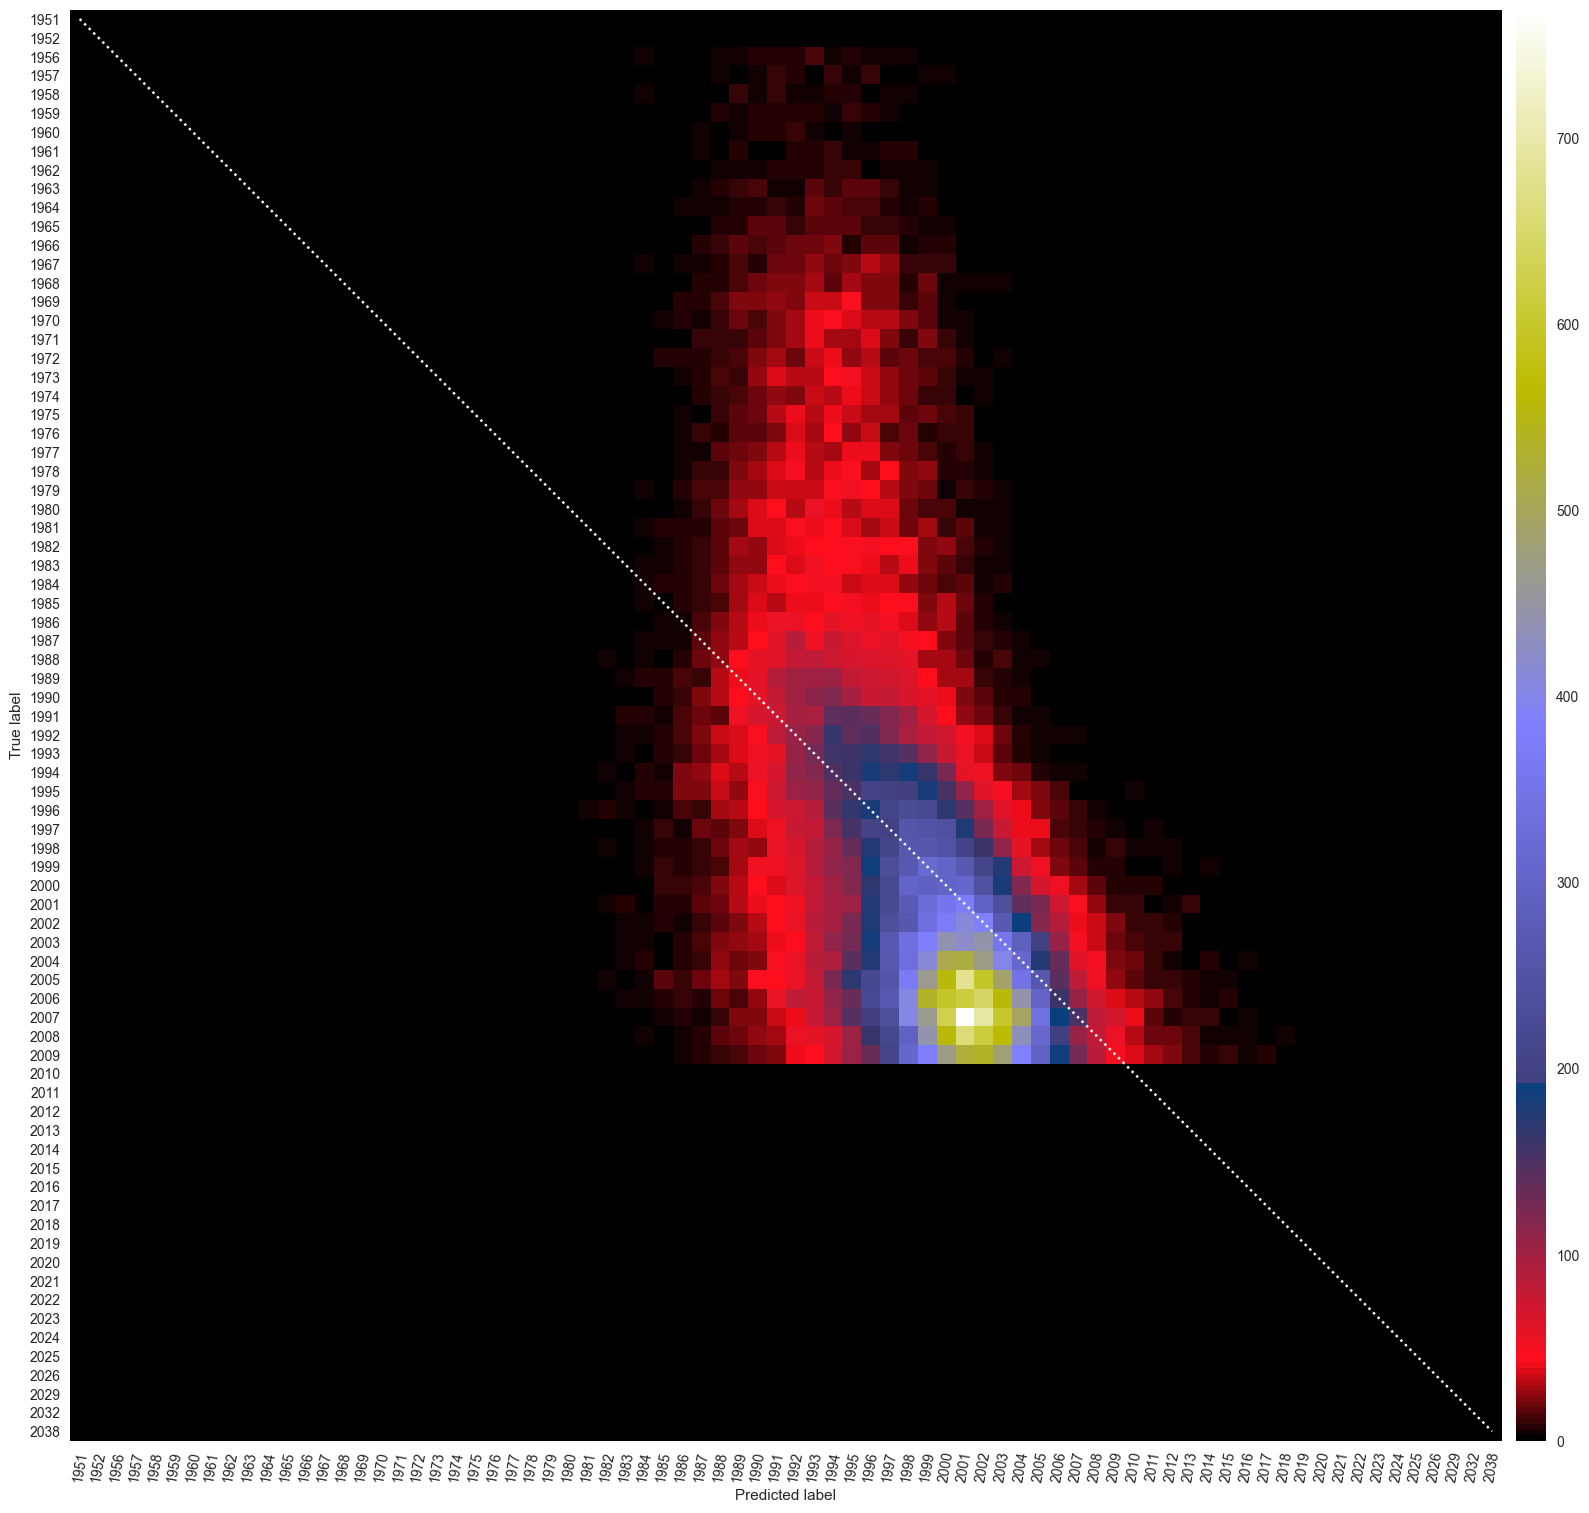

In [7]:
print_store_results(searches, predictions, "lr")

---
## RandomForestRegressor
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA gives better results than PCA with even less components (53). 
- LDA gives better results with l-max-Normalization + MinMax instead of MinMax, StandardScaling, MinMax+StandardScaling.
- The following results are with a preprocess of MinMax + l-max-Normalization + LDA:
    - Keeping the number of trees to 200 with samples percentage per tree of 10% (for computational reasons):
        - The best covariance estimators are EllipticEnvelope (MinCovDet) and OAS, over EmpiricalCovariance and no-shrinkage: R^2=0.3033, MSE=76.77
        - The best "contamination" amount for EllipticEnvelope is 0.001, over 0.2, 0.1, 0.05, 0.0001, but the difference is minimal
        - The only difference is that the OAS covariance estimator takes much less time to compute instead of EllipticEnvelope
    - Incrementing the number of trees (500) and reducing the percentage of samples per tree (2.5%) (for computational reasons), the results were a bit worse but very similar
    - Decrementing the number of trees (5) with samples percentage per tree of 100%, the results were far worse (R^2=0.16, MSE=92)
- Therefore the best combination is:
    - MinMax preprocess + l-max-Normalization + LDA preprocess with OAS covariance estimator and "eigen" as solver
    - RandomForest with 200 estimators and 100% of sample per estimator: R^2=0.3195, MSE=74.98
    - There is a very big downside with this configuration: it is more than 2GB of model size, in comparison with the 328MB of the same model but with 0.1% of samples per tree (the results are the one above).

In [9]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "rf__max_samples": [0.1],
    "rf__criterion": ["squared_error"],
    "rf__n_estimators": [200],
}

searches, predictions = gridSearch("rf", RandomForestRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.1, 'rf__n_estimators': 200}. R^2: 0.30409677679950253. MSE: 76.68606012914228


----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.1, 'rf__n_estimators': 200}. R^2: 0.30409677679950253. MSE: 76.68606012914228
		min-max + lmax + lda2: number of components=53, total variance=1.4228327061439383

SAVED: ----> min-max + lmax + lda2 data. R^2: 0.30409677679950253


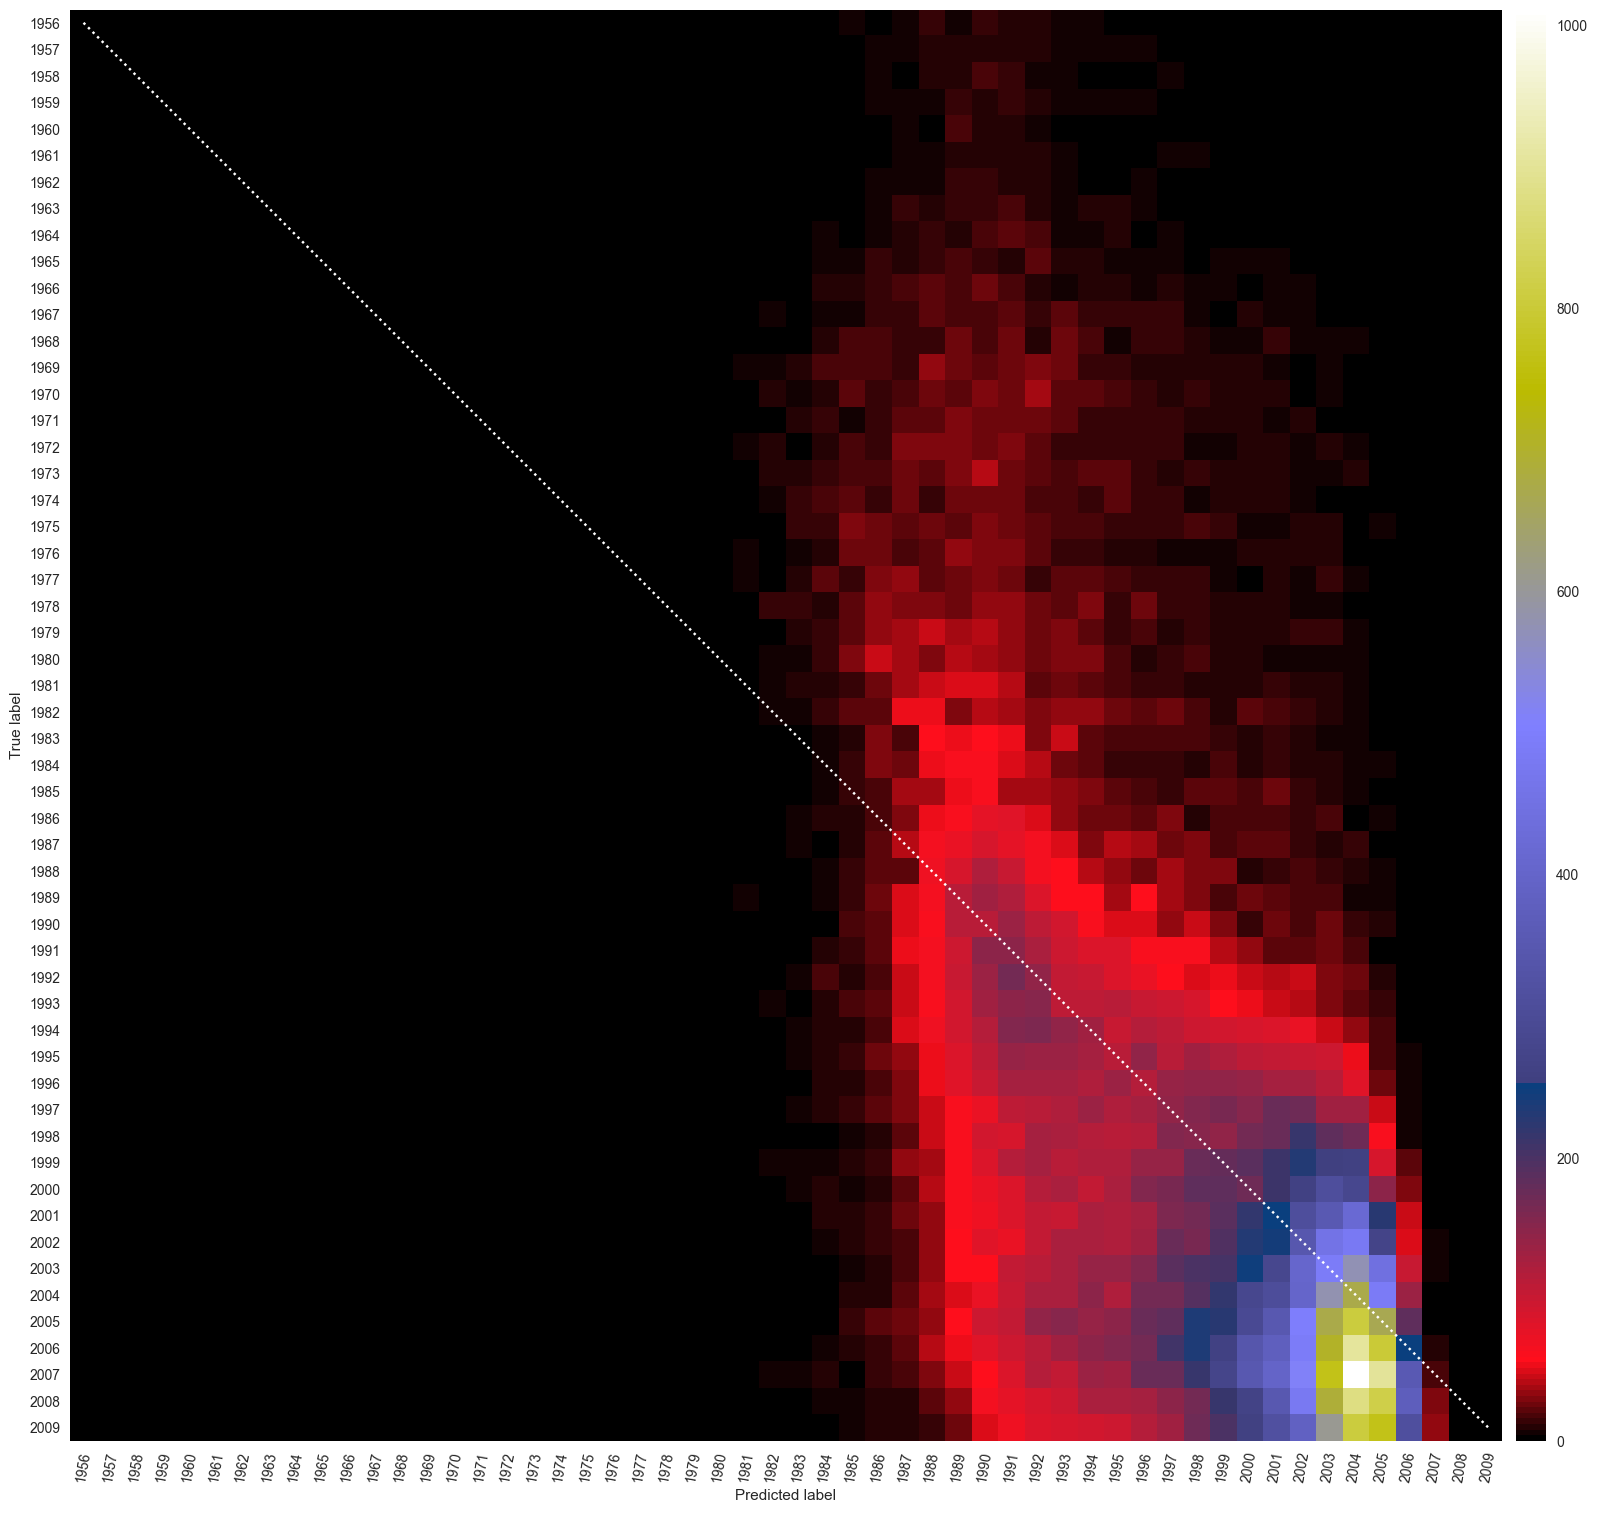

In [10]:
print_store_results(searches, predictions, "rf")

---
## KNN
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- The following search was not exhaustive: we not try all the possible combinations, but we followed the more promising paths
- The best result is R^2=0.3224 , MSE=74.66 with:
    - MinMax + l-max-Normalization + LDA. It performed better than PCA (and its combinations with preprocessing techniques), l-1-Normalization + LDA, l-2-Normalization + LDA, MinMax + l-1-Normalization + LDA, MinMax + l-2-Normalization + LDA
    - Best covariance estimator for LDA is OAS, over EllipticEnvelope, EmpiricalCovariance and no-shrinkage
    - Best KNN metric is cosine, over cityblock, euclidean, nan_euclidean, with "weights"="distance" over "uniform"
    - Best number of neighbors is 20 (tried in this order 5,30,25,20,15,17,18,19)

In [11]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "knr__n_neighbors": [20],
    "knr__weights": ["distance"],  # "uniform"
    "knr__metric": [
        # "cityblock",
        "cosine",
        # "euclidean",
        # "nan_euclidean",
    ],
}

searches, predictions = gridSearch("knr", KNeighborsRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
----> min-max + lmax + lda2 data. Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 20, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.3224368838659665. MSE: 74.66504555932104


----> min-max + lmax + lda2 data. Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 20, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.3224368838659665. MSE: 74.66504555932104
		min-max + lmax + lda2: number of components=53, total variance=1.4228327061439383

SAVED: ----> min-max + lmax + lda2 data. R^2: 0.3224368838659665


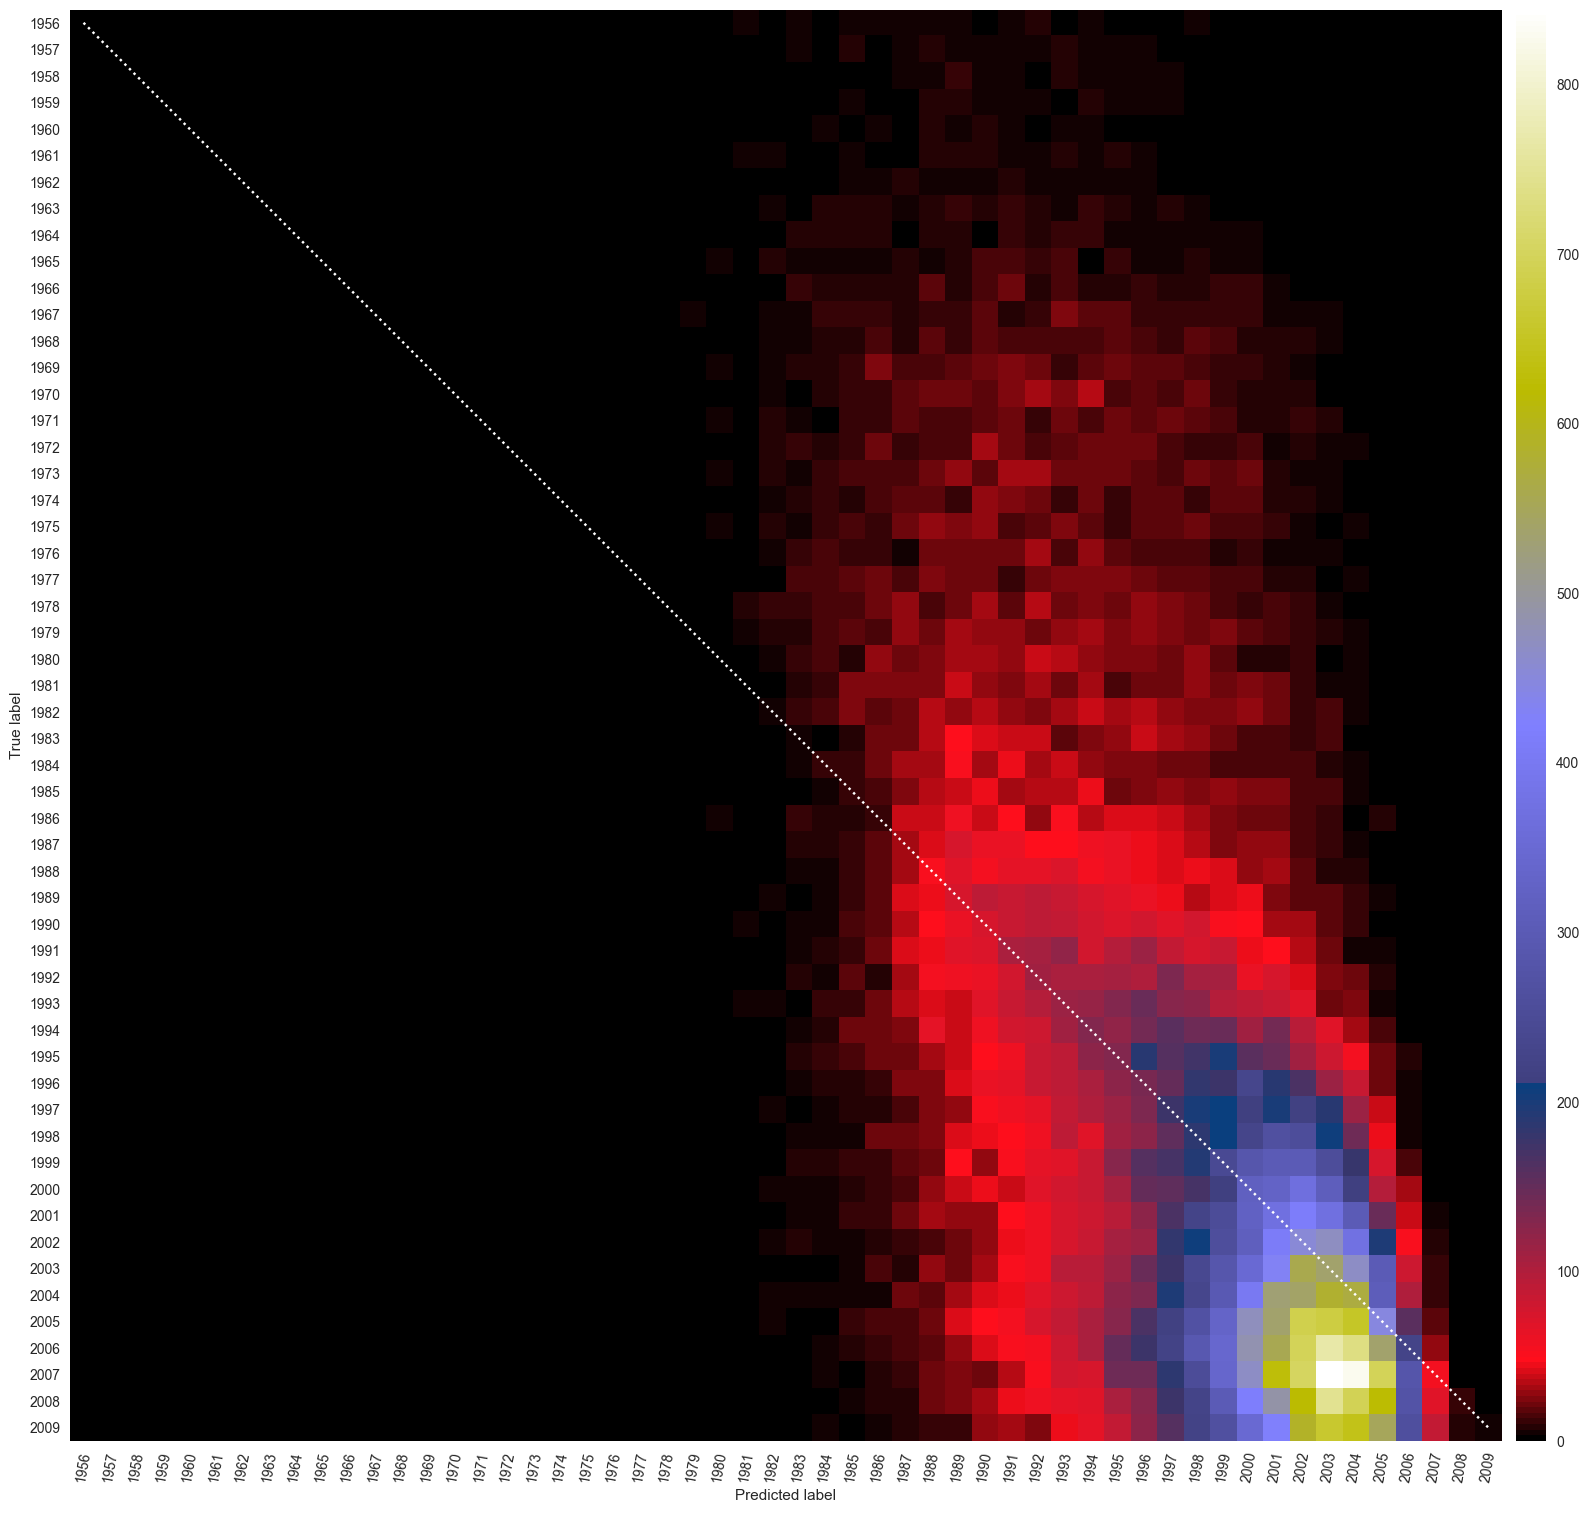

In [12]:
print_store_results(searches, predictions, "knr")